# Getting Started

Here we go through a simplified motor simulation to get you started. Let's start by importing the solidpy module.

In [120]:
import sys
sys.path.append('../')
import numpy as np
from solidpy import Bates, Star, CustomGeometry
from solidpy import Motor, Propellant, Environment, Rail
from solidpy import BurnSimulation, Export

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [121]:
%matplotlib inline

## Setting Up a Simulation

### Creating your rocket propellant

Here we need to define some of the properties of our chosen propellant.
Among them is the specific heat ratio ($\gamma$), propellant density ($\rho$), molecular mass of the products of combustion ($M$) and adiabatic flame temperature ($T$). These can be easily obtained for any given composition from a thermochemical equilibrium solver such as [PROPEP](http://rocketworkbench.sourceforge.net/equil.phtml).

We'll also need some parameters regarding how the propellant burn rate behaves. Solid propellant burn rates are commonly modelled solely as a function of the local static chamber pressure, following semi-empirical relation known as Saint-Robert's law or Vielle's Law:

$r = a{P_0}^n$

Where $P_0$ represents the chamber stagnation pressure. The $a$ and $n$ are respectively called the *linear* and *exponential* ballistic coefficients and should be obtained empirically for your given propellant formulation and manufacturing process. Note that a value of *n < 1* is required for a stable burn.

Here we'll create an instance of the KNSB (65% KNO3, 35% sorbitol) propellant, widely used by Projeto Jupiter's propulsion team. Burn rate coefficients have been sourced from [Richard Nakka's Experimental Rocketry Site](https://www.nakka-rocketry.net).

In [122]:
KNSB = Propellant(
    specific_heat_ratio=1.1361,
    density=1700,
    products_molecular_mass=39.9e-3,
    combustion_temperature=1600,
    burn_rate_a=5.8,
    burn_rate_n=0.22
)

Alternatively, SolidPy allows you to input a customized *Burnrate (mm/s) x Pressure (MPa)* curve by passing on a CSV file that will be interpolated. This allows for more flexibility regarding propellant behaviour, and for many formulations there is raised data from experiments available online.

In [123]:
KNSB = Propellant(
    specific_heat_ratio=1.1361,
    density=1700,
    products_molecular_mass=39.9e-3,
    combustion_temperature=1600,
    interpolation_list="../data/burnrate/KNSB.csv"
)

That's everything required to fully characterize the propellant that will be used in your motor!
You can now access some of the instance's methods, such as calculating the theoretical value for characteristic velocity ($c*$), in m/s:

In [124]:
KNSB.evaluate_cstar()

908.1465077764462

### Setting up your grain geometry

With the composition of our propellant well-defined, we'll now construct the physical propellant grains. This will involve mostly geometrical parameters such as outer diameter, height and port shape. 

SolidPy was rencently updated to support a wider variety of grain ports. Currently, there are standards for both *BATES* and *STAR* geometries and the user may generate a shape from any well-behaved polar equation. The regression of complex port geometries are evaluated through the employment of [fast-marching methods](https://en.wikipedia.org/wiki/Fast_marching_method).

Here, we'll define the grain of the *Leviatã*, a class L motor designed by Projeto Jupiter and static-fired at Apr 03, 2022 at Pirassununga USP campus:

In [125]:
Bates_Grain = Bates(
        outer_radius=71.92 / 2000,
        inner_radius=31.92 / 2000,
    )

You can see that both radius have been passed with the *D/2000*, where D represents the diameter value in milimiters. Since SolidPy standardized on receiving all inputs in [International Units](https://en.wikipedia.org/wiki/International_System_of_Units), this practice allows for easier transfer between the code and other software such as CAD.

Note that also that the *initial_height* has not been passed. However, if we check the respective attribute in the instance we created:

In [126]:
height = Bates_Grain.height
print("Grain height: {} mm".format(height*1000))

Grain height: 123.84 mm


The Grain classes defines the grain height as an optional parameter. If *None* is passed, SolidPy employs a method which calculates the optimal height in order to make the $K_n(t) = \frac{A_b(t)}{A_t}$ curve symmetric. This allows for a neutral burn profile, which is usually desired during motor design. Don't let that fool you though, you're free to create a grain as tall as you want!

By now, we can combine our two previously defined objects (Propellant and Grain), and obtain a very useful piece of information: the mass of each of our grains!

In [127]:
density = KNSB.density
volume = Bates_Grain.volume
mass = density*volume
print("Grain mass: {:.2f} g".format(mass*1000))

Grain mass: 686.79 g


### Creating a Motor

To create our solid motor, we'll be using the *Motor* class, and the required arguments must given. These are mostly related to **combustion chamber** and **nozzle** geometric properties, as well as the **number of grains** and the **Grain** object itself.

Again, we'll be creating the previously designed and built *Leviatã* motor, and placing 4 of its grains inside it:

In [128]:
Leviata = Motor(
        Bates_Grain,
        grain_number=4,
        chamber_inner_radius=77.92 / 2000,
        nozzle_throat_radius=17.5 / 2000,
        nozzle_exit_radius=44.44 / 2000,
        nozzle_angle=15 * np.pi / 180,
        chamber_length=600 / 1000,
    )

Just like when creating our grain, the length parameter is optional, and if not passed will be calculated by adding each grain height.

### Firing it up!

Here we get to the icing on the cake part of the simulation. All up until now, we've been mostly setting up the required inputs to operate our thermodynamic model. From now on, we can start plugging in numbers, solving (differential) equations, and of course, obtain some beautiful values and plots!

This will be done through the BurnSimulation class, which is mostly self-contained. It requires only two inputs: your defined Motor object and Propellant composition:

Total Impulse: 3436.78 Ns
Max Thrust: 1608.71 N at 1.22 s
Mean Thrust: 1437.22 N
Max Chamber Pressure: 47.93 bar at 1.22 s
Mean Chamber Pressure: 42.23 bar
Propellant mass: 2745.95 g
Specific Impulse: 127.63 s
Burnout Time: 2.41 s

2.406751261872833


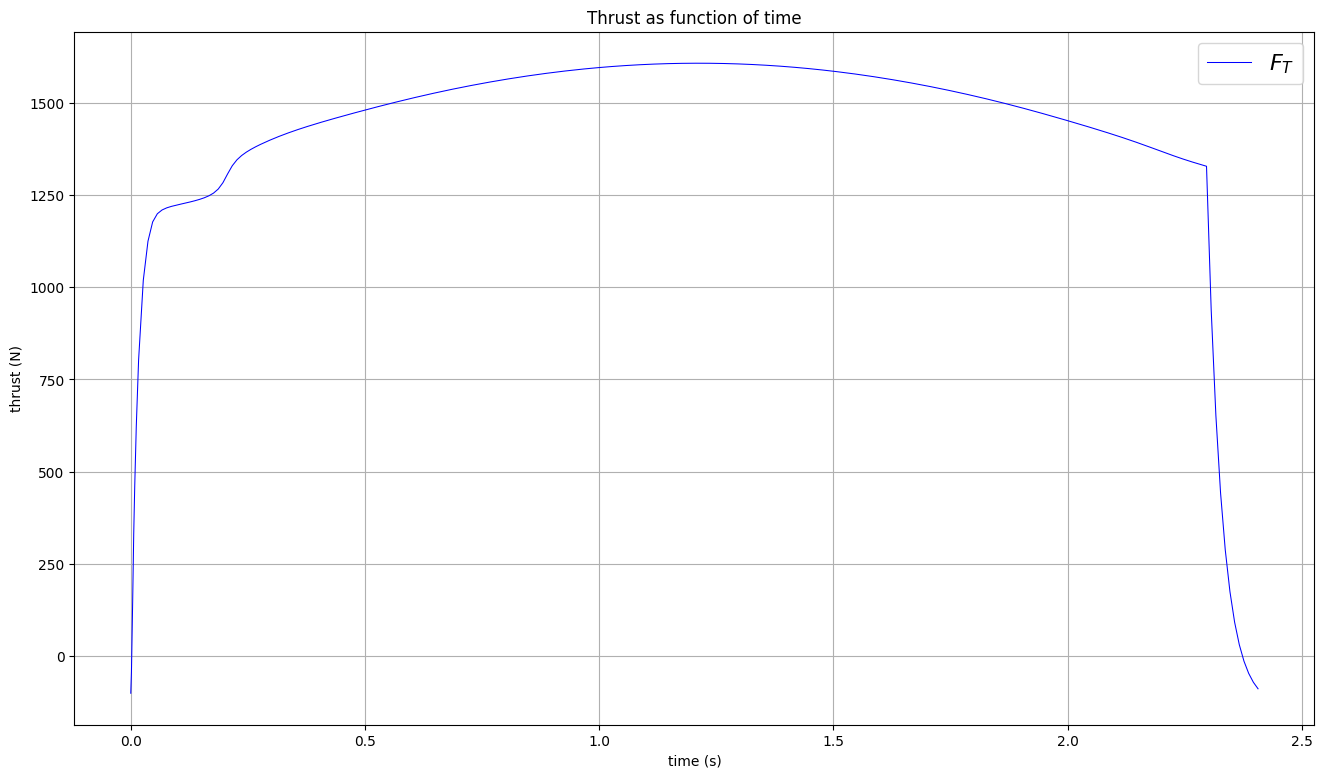

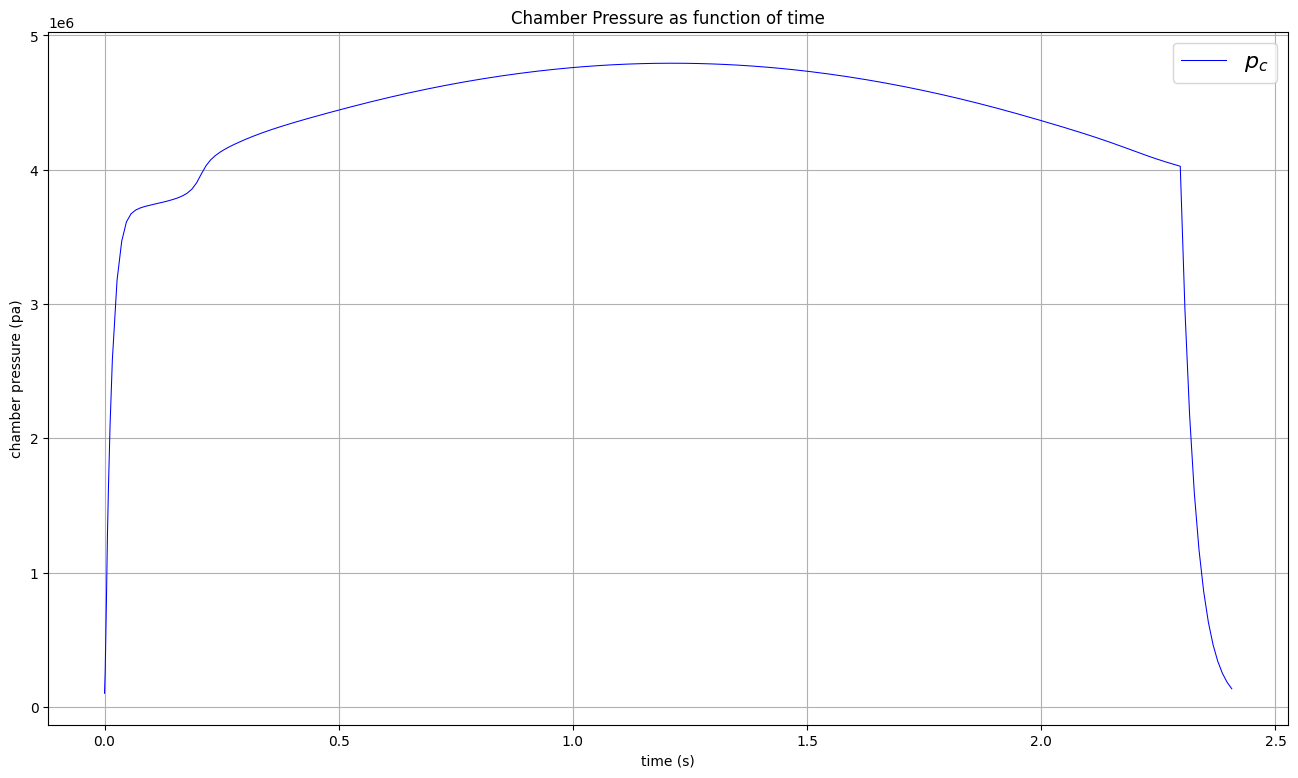

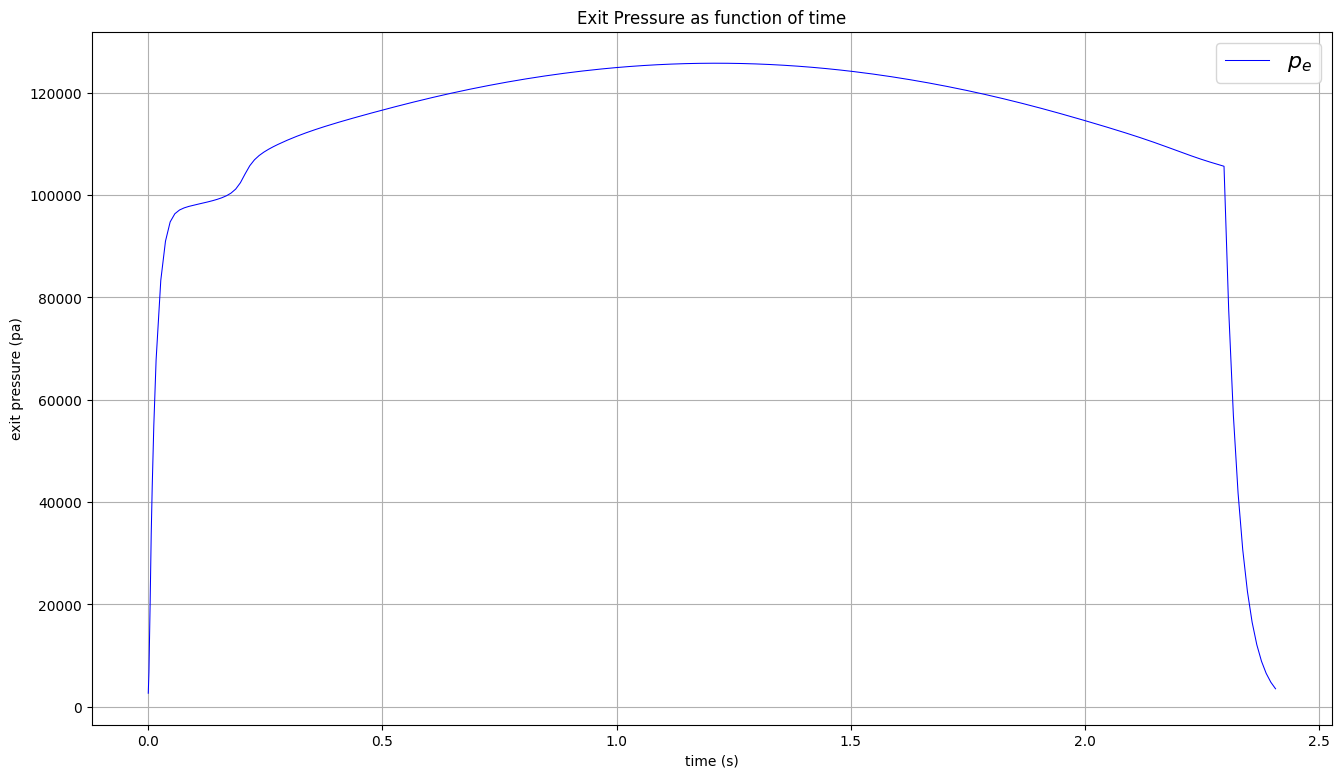

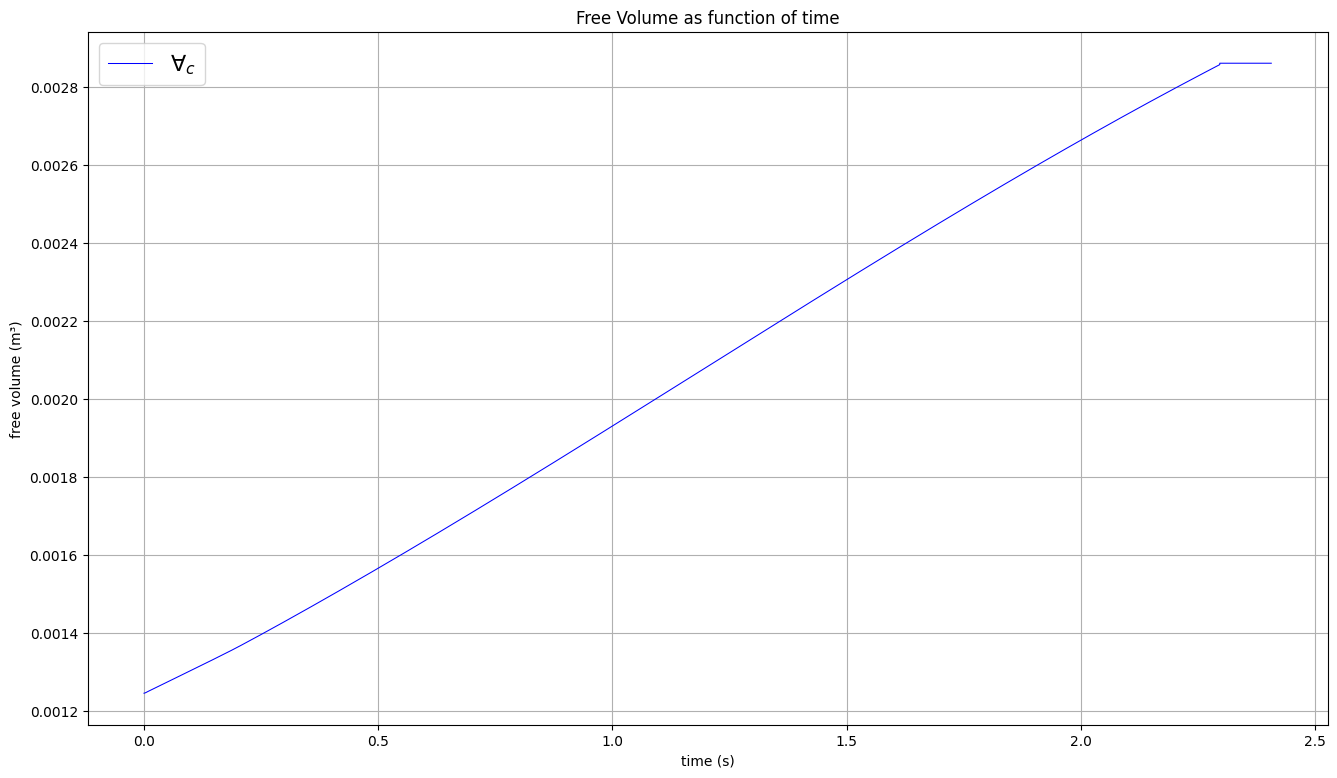

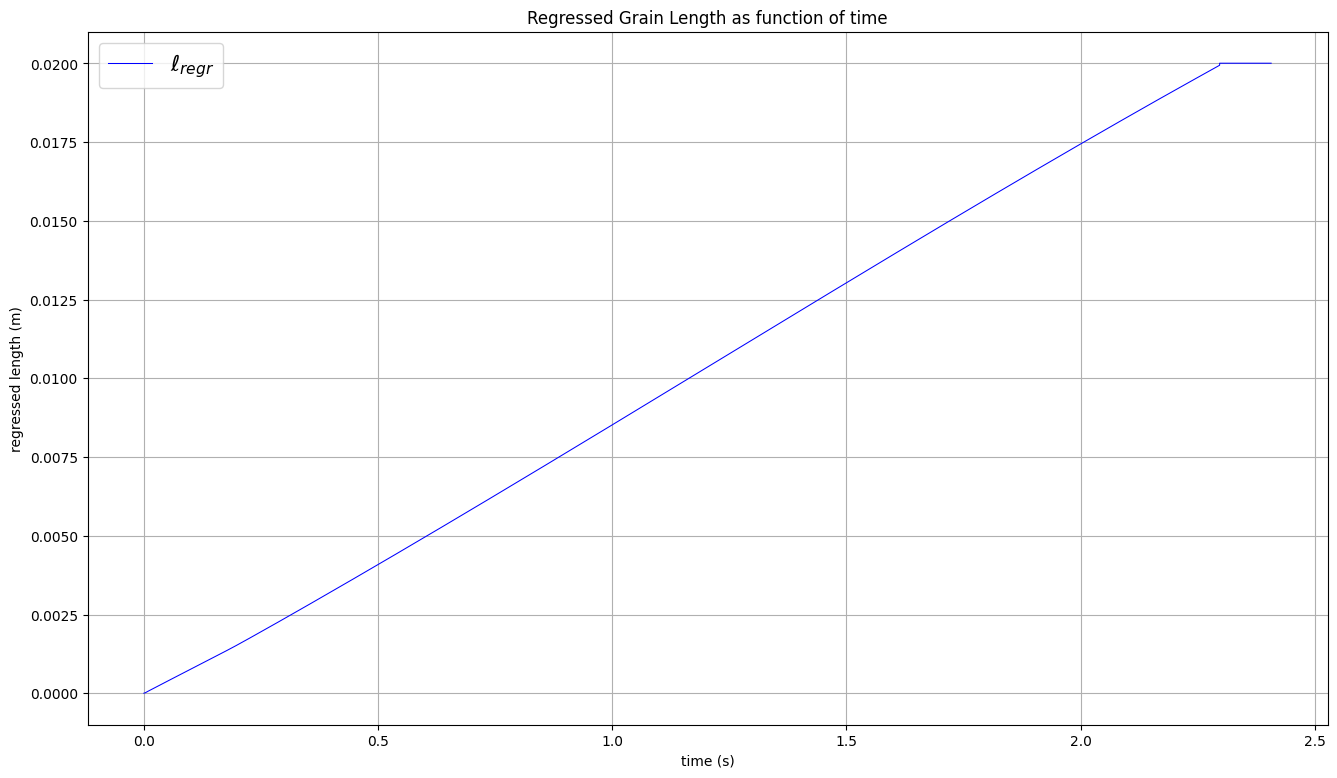

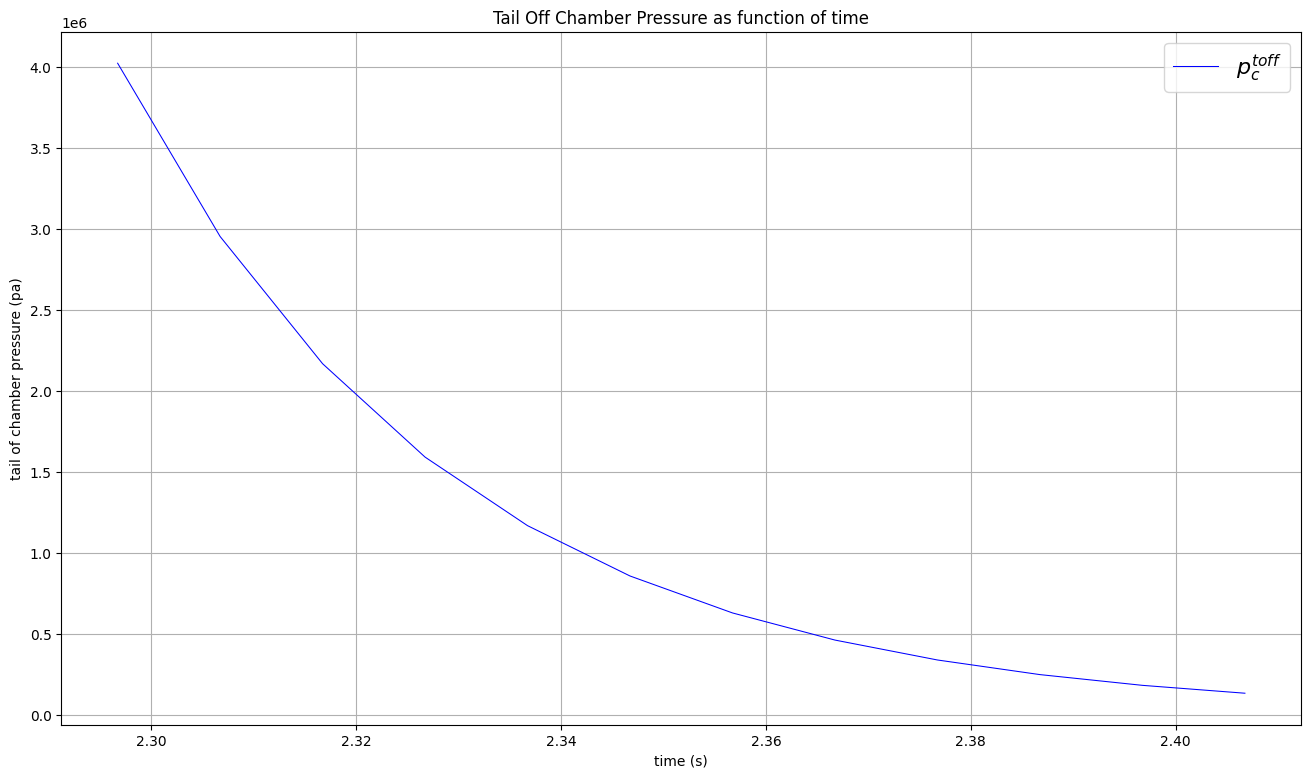

In [172]:
from solidpy.Burn import BurnExport

Simulation = BurnSimulation(Leviata, KNSB)


SimulationData = BurnExport(Simulation)
SimulationData.all_info()
SimulationData.plotting()



236
248
2.406751261872833


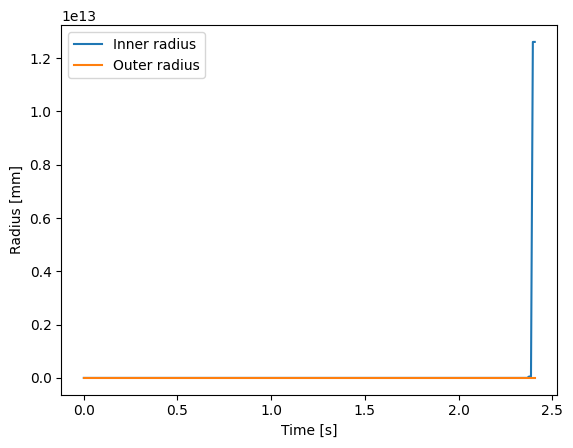

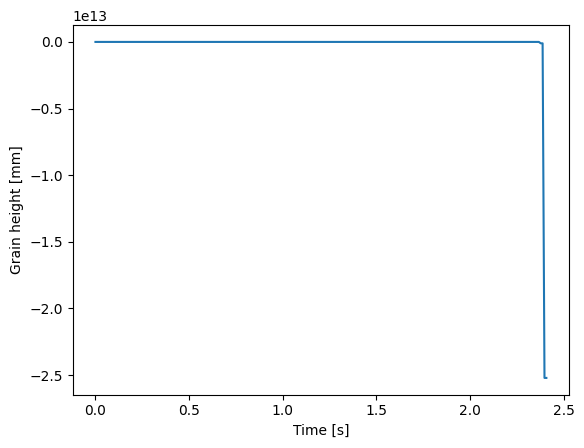

In [186]:
#get burn rate
burnrate = KNSB.evaluate_burn_rate(Simulation.chamber_pressure)

#evaluate inner radius of the grain through time based on burn rate
inner_radius = np.zeros(len(Simulation.time))
for i in range(len(Simulation.time)):
    inner_radius[i] = (1000*Bates_Grain.initial_inner_radius + burnrate[i]*1000*Simulation.time[i])

#evaluate grain height through time based on burn rate
grain_height = np.zeros(len(Simulation.time))
for i in range(len(Simulation.time)):
    grain_height[i] = (1000*Bates_Grain.initial_height - 2*burnrate[i]*1000*Simulation.time[i])

#remove the 12 last values of the arrays to numerical instabilities
inner_radius = inner_radius[:-12]
grain_height = grain_height[:-12]
print(len(inner_radius))

#linear extrapolation of the last values of the arrays to make them index compatible with the other arrays
for i in range(12):
    inner_radius = np.append(inner_radius, inner_radius[-1] + (Simulation.time[-1]-Simulation.time[-2])*(inner_radius[-2] - inner_radius[-3])/(Simulation.time[-2] - Simulation.time[-3]))
    grain_height = np.append(grain_height, grain_height[-1] + (Simulation.time[-1]-Simulation.time[-2])*(grain_height[-2] - grain_height[-3])/(Simulation.time[-2] - Simulation.time[-3]))

print(len(inner_radius))


#evaluate grain volume through time based on burn rate
grain_volume = np.zeros(len(Simulation.time))
for i in range(len(Simulation.time)):
    grain_volume[i] = np.pi*(Bates_Grain.outer_radius**2 - inner_radius[i]**2)*grain_height[i]

print(Simulation.time[-1])

#plot grain inner radius


import matplotlib.pyplot as plt

#plot inner radius and outer radius of the grain in function of time in the same plot
plt.plot(Simulation.time, inner_radius, label='Inner radius')
plt.plot(Simulation.time, 1000*Bates_Grain.outer_radius*np.ones(len(Simulation.time)), label='Outer radius')
plt.xlabel('Time [s]')
plt.ylabel('Radius [mm]')
plt.legend()
plt.show()

#plot the grain height in function of time
plt.plot(Simulation.time, grain_height)
plt.xlabel('Time [s]')
plt.ylabel('Grain height [mm]')
plt.show()







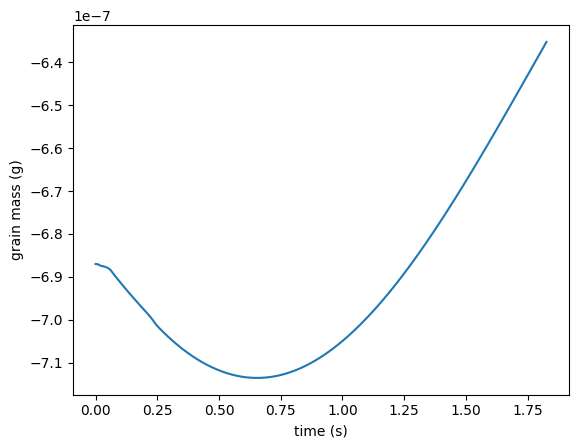

In [131]:
#evaluate the grain burn area through time
burn_area = np.zeros(len(time_grain_raidus))
for i in range(len(time_grain_raidus)):
    burn_area[i] = 2*(Bates_Grain.outer_radius**2 - inner_radius[i]**2)*np.pi + 2*np.pi*inner_radius[i]*height[i]

#evaluate the grain burn volume through time
burn_volume = np.zeros(len(time_grain_raidus))
for i in range(len(time_grain_raidus)):
    burn_volume[i] = np.pi*(Bates_Grain.outer_radius**2 - inner_radius[i]**2)*height[i]

#evaluate the grain volume through time
grain_volume = np.zeros(len(time_grain_raidus))
for i in range(len(time_grain_raidus)):
    grain_volume[i] = Bates_Grain.volume - burn_volume[i]
#pass the volume from mm^3 to cm^3
grain_volume = grain_volume/1000


#evaluate the grain mass through time
grain_mass = np.zeros(len(time_grain_raidus))
for i in range(len(time_grain_raidus)):
    grain_mass[i] = grain_volume[i]*KNSB.density

#pass the mass from g to kg
grain_mass = grain_mass/1000

#plot the grain mass through time
plt.plot(time_grain_raidus, grain_mass)
plt.xlabel('time (s)')
plt.ylabel('grain mass (g)')
plt.show()

In [132]:
#evaluate the mass flux through time
mass_flux = np.zeros(len(time_grain_raidus))
for i in range(len(time_grain_raidus)):
    mass_flux[i] = grain_mass[i]/time_grain_raidus[i]
    

C:\Users\55989\AppData\Local\Temp\ipykernel_112412\959225949.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  mass_flux[i] = grain_mass[i]/time_grain_raidus[i]
